# **Resources:**
- https://github.com/slundberg/shap
- H2O Explainability best practices: https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/model-interpretability/interpreting_models.ipynb


## **Preparation**


In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Extend cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import shap

import h2o
from h2o.estimators import H2OTargetEncoderEstimator

In [4]:
try:
    h2o.cluster().shutdown()
except:
    pass 

In [5]:
#Limit to 3 threads and 8GB memory
h2o.init(nthreads=3, max_mem_size=8)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,15 days 4 hours 2 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 9 days
H2O_cluster_name:,H2O_from_python_aishwaryaadiki_plrork
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.038 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


## Load Data

In [1]:
train = h2o.import_file('SBA_loans_train.csv')
test = h2o.import_file('SBA_loans_test.csv')

NameError: name 'h2o' is not defined

In [5]:
# Choose which columns to encode
cat_columns = ["City","State","Bank","BankState", "UrbanRural", "FranchiseCode",
               "NewExist", "RevLineCr","LowDoc", "Zip"]
response = "Defaulted"

train[cat_columns+[response]] = train[cat_columns+[response]].asfactor()
test[cat_columns+[response]] = test[cat_columns+[response]].asfactor()

In [6]:
test

City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Defaulted
RANTOUL,IL,61866,BUSEY BANK,IL,0,84,1,2,0,0,1,0,N,Y,42000,0,42000,33600,0
BOISE,ID,83704,WELLS FARGO BANK NATL ASSOC,SD,0,84,7,1,0,0,1,0,N,N,15000,0,15000,13500,0
CAROL STREAM,IL,60188,"SOMERCOR 504, INC.",IL,0,240,19,1,15,0,1,0,N,N,497000,0,497000,497000,0
SOMERSWORTH,NH,3878,CITIZENS BANK NATL ASSOC,NH,235610,84,21,1,0,21,1,1,Y,N,20000,0,20000,10000,0
CHERRY HILL,NJ,8002,CITIZENS BANK NATL ASSOC,RI,541511,84,2,2,1,3,1,1,N,N,100000,0,100000,50000,0
SALIDA,CO,81201,FIRST SOUTHWEST BANK,CO,0,180,3,1,0,0,1,0,N,N,273000,0,273000,221130,0
VALLEY STREAM,NY,11580,JPMORGAN CHASE BANK NATL ASSOC,IL,561990,62,6,1,1,6,0,1,N,N,99250,0,100000,50000,1
UNION CITY,NJ,7087,VALLEY NATIONAL BANK,NJ,445299,84,7,1,8,15,1,1,Y,N,156215,0,25000,12500,0
POCATELLO,ID,83201,FIRST-CITIZENS BK & TR CO,CO,811192,216,4,1,0,0,1,2,N,N,314000,0,314000,235500,0
ST. CLOUD,MN,56301,WELLS FARGO BANK NATL ASSOC,MN,0,84,40,1,0,0,1,0,0,N,200000,0,200000,150000,0


## **H2O `H2OGradientBoostingEstimator` with parameters:**
```
nfolds=5,
ntrees=500,
stopping_rounds=5,
stopping_metric='AUCPR',
seed=1234,
keep_cross_validation_predictions = False
```
Display model performance on `test` dataset using `model_performance` function.

In [7]:
from h2o.estimators import H2OGradientBoostingEstimator

predictors = train.columns
predictors.remove("Defaulted")
print("Predictor columns:", predictors)    
response_col = "Defaulted"
gradientBoost = H2OGradientBoostingEstimator(nfolds=5, ntrees=500, stopping_rounds=5, stopping_metric='AUCPR', seed=1234, 
                                             keep_cross_validation_predictions = False)

gradientBoost.train(cat_columns, response, training_frame= train)
model_summary = gradientBoost.summary()

Predictor columns: ['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [8]:
model_summary

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,95.0,95.0,78557.0,5.0,5.0,5.0,24.0,32.0,30.515789


In [9]:
print("Model AUCPR:", gradientBoost.model_performance(test).aucpr())
gradientBoost.model_performance(test).confusion_matrix()

Model AUCPR: 0.4966089837071746


,0,1,Error,Rate
0,77634.0,15055.0,0.1624,(15055.0/92689.0)
1,8254.0,11453.0,0.4188,(8254.0/19707.0)
Total,85888.0,26508.0,0.2074,(23309.0/112396.0)


## **Perumtation Importance:**

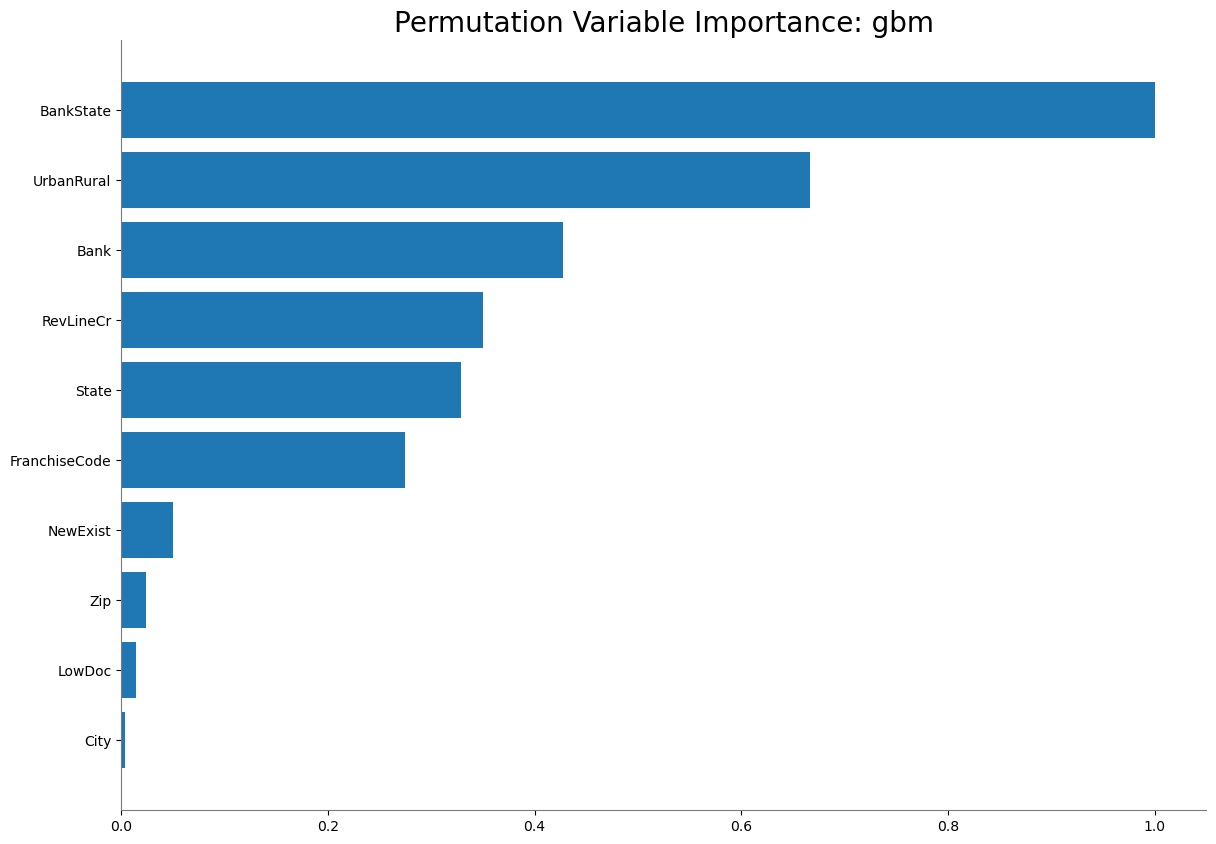

Variable,Relative Importance,Scaled Importance,Percentage
BankState,0.0914350,1.0,0.3184985
UrbanRural,0.0609018,0.6660670,0.2121413
Bank,0.0390529,0.4271115,0.1360344
RevLineCr,0.0320394,0.3504068,0.1116040
State,0.0300949,0.3291404,0.1048307
FranchiseCode,0.0251354,0.2748993,0.0875550
NewExist,0.0045962,0.0502673,0.0160101
Zip,0.0021905,0.0239564,0.0076301
LowDoc,0.0013358,0.0146091,0.0046530
City,0.0002994,0.0032746,0.0010430


In [12]:
gradientBoost.permutation_importance_plot(test)

## **Analysis:**
- **What is most important feature?**
    The most important feature is BankState, with a Scaled Feature importance of 1(obviously because it is scaled) and feature percentage of 0.3185437
  
- **Can you tell how feature is impacting (direction) probability? If yes, specify the direction. If not, explain why not.**
      Based on the information given, we can only tell how important a feature is. We cannot tell which direction the probablity of the feature would be.

# **Partial Dependency Plots**

- Calculated and plotted PDP plot for the following columns: `"UrbanRural","SBA_Appv","DisbursementGross"`
- `nbins=52,figsize=(10, 10)` 

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


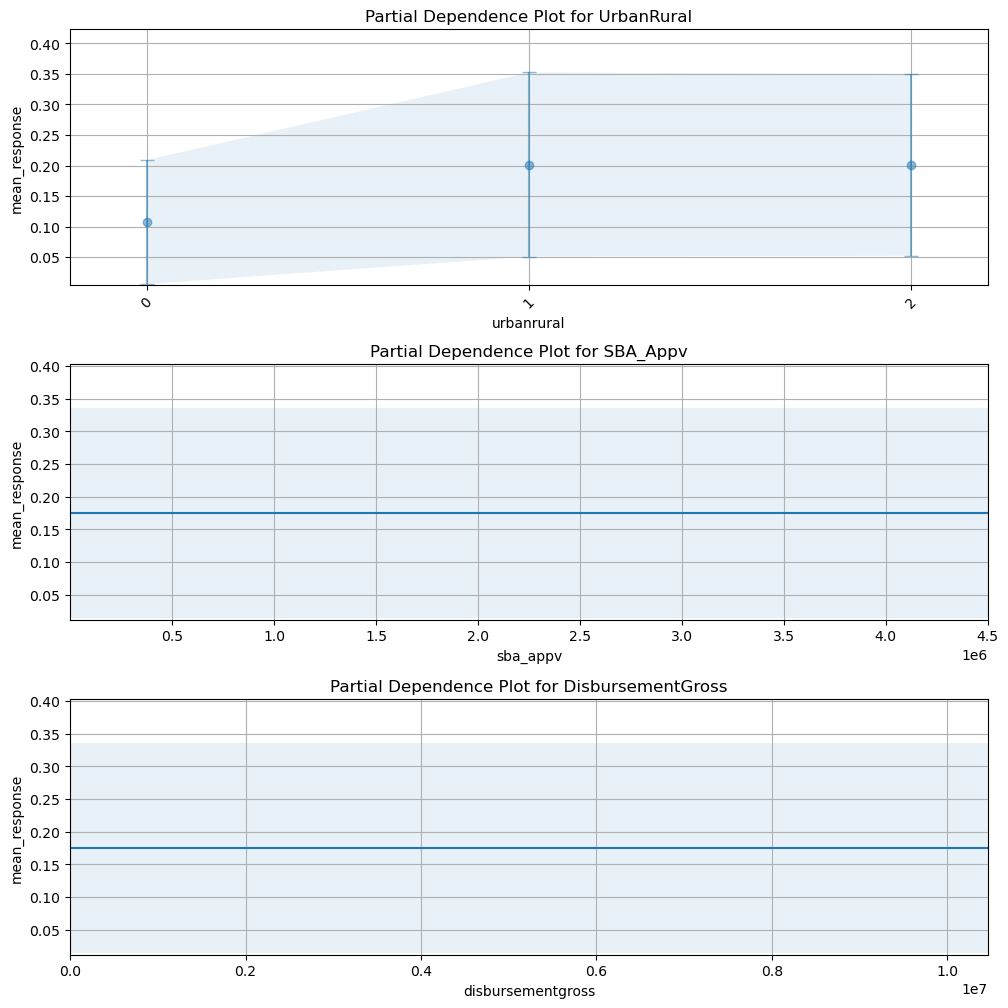

In [13]:
gradientBoost.partial_plot(test, cols=["UrbanRural", "SBA_Appv", "DisbursementGross"], nbins=52,figsize=(10, 10));

### **Analysis:**
- An **UrbanRural** value of 1 indicates an urban neighborhood, and 2 indicates a rural neighborhood. Based on that, it seems like both urban and rural small business are equally as likely to default on their loan.
- Features **SBA_Appv** and **DisbursementGross** have no real effect on whether or not the small business would default on their loan payments. 

# **SHAPLEY PLOTS:**

Calculated and display summary plot of Shapley values. Used`test` dataset to calculate Shapley values.

In [13]:
class H2OProbWrapper:
    def __init__(self, h2o_model, feature_names):
        self.h2o_model = h2o_model
        self.feature_names = feature_names

    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        self.dataframe= pd.DataFrame(X, columns=self.feature_names)
        self.predictions = self.h2o_model.predict(h2o.H2OFrame(self.dataframe)).as_data_frame().values
        return self.predictions.astype('float64')[:,-1] #probability of True class

In [14]:
feature_names = list(train.columns)
h2o_wrapper = H2OProbWrapper(gradientBoost,feature_names) 

In [15]:
test_df = h2o.as_list(test, use_pandas=True)
test_df

/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Defaulted
0,RANTOUL,IL,61866,BUSEY BANK,IL,0,84,1,2.0,0,0,1,0,N,Y,42000,0,42000,33600,0
1,BOISE,ID,83704,WELLS FARGO BANK NATL ASSOC,SD,0,84,7,1.0,0,0,1,0,N,N,15000,0,15000,13500,0
2,CAROL STREAM,IL,60188,"SOMERCOR 504, INC.",IL,0,240,19,1.0,15,0,1,0,N,N,497000,0,497000,497000,0
3,SOMERSWORTH,NH,3878,CITIZENS BANK NATL ASSOC,NH,235610,84,21,1.0,0,21,1,1,Y,N,20000,0,20000,10000,0
4,CHERRY HILL,NJ,8002,CITIZENS BANK NATL ASSOC,RI,541511,84,2,2.0,1,3,1,1,N,N,100000,0,100000,50000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112391,HURRICANE,WV,25526,"WESBANCO BANK, INC.",WV,0,60,6,1.0,0,0,1,0,N,Y,23269,0,24700,19760,0
112392,ADA,OK,74820,VISION BANK NATL ASSOC,OK,722211,78,2,1.0,10,0,1,2,0,N,120000,0,120000,60000,1
112393,LA MIRADA,CA,90638,BBCN BANK,CA,621999,78,1,2.0,0,0,0,1,N,N,20000,0,20000,17000,1
112394,LOS ANGELES,CA,90021,CAPITAL ONE NATL ASSOC,VA,315212,84,3,1.0,4,3,0,1,N,N,25000,0,25000,12500,0


In [16]:
explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob, test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
Using 112396 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


███████████████████████████████████████████████████████| (done) 100%


### **Plotted individual Shapley values plots for records 0,1 and 4 in test dataset, for the total of 3 plots.**


In [ ]:
shap.initjs()
shap_values = explainer.shap_values(test_df.iloc[0], nsamples=50) # record 0

In [20]:
shap.force_plot(explainer.expected_value, shap_values, test_df.iloc[0])

### Explanation for Record 0
It seems that State is an important feature for record 0, but since we don't know if it's urban or rural, and also because the BANK is important too, the PREDICTION (probability that record 0 small business defaulted on the loan) = 0.041820257190519

In [21]:
shap_values = explainer.shap_values(test_df.iloc[1], nsamples=50) # record 1
shap.force_plot(explainer.expected_value, shap_values, test_df.iloc[1])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


### Explanation for Record 1
It seems that State is an important feature for record 1, and once againt since we don't know if it's urban or rural, and also because the BANK is important too, the PREDICTION (probability that record 0 small business defaulted on the loan) = 0.05

In [22]:
shap_values = explainer.shap_values(test_df.iloc[4], nsamples=50) # record 1
shap.force_plot(explainer.expected_value, shap_values, test_df.iloc[4])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/opt/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


### Explanation for Record 4
It seems that UrbanRural is an important feature for record 4, and this time we know the small business is located in an urban area. However, it seems that the BankState is negatively effecting the prediction, the PREDICTION (probability that record 0 small business defaulted on the loan) = 0.28

Out of records 0,1, and 4, small business 4 is most likely to default or have defaulted.

## **Surrogate Model**

Train single decision tree surrogate model with 4 levels (depth 4) and plot the result.

If you run into problem with using Graphviz, you can generate the png file without it, look for below code in the documentation:
```
java -cp h2o-genmodel.jar hex.genmodel.tools.PrintMojo --tree 0 -i "/path/to/model.zip" -o tree.png --format png
open tree.png
```
Documentation:

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/productionizing.html#viewing-a-mojo-model


In [41]:
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
model_id = 'dt_surrogate_mojo' # gives MOJO artifact a recognizable name

# initialize single tree surrogate model
surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                     sample_rate=1,     # use all rows in that tree
                                     mtries=-2,         # use all columns in that tree
                                     max_depth=4,       # shallow trees are easier to understand
                                     seed=12345,        # random seed for reproducibility
                                     model_id=model_id) # gives MOJO artifact a recognizable name

# train single tree surrogate model
surrogate.train(cat_columns, response, training_frame=train)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Generated MOJO path:
 /Users/aishwaryaadiki/Downloads/dt_surrogate_mojo.zip


In [53]:
from h2o.backend import H2OLocalServer                            # for plotting local tree in-notebook

import numpy as np   # array, vector, matrix calculations

# system packages for calling external graphviz processes
import os
import re
import subprocess

# in-notebook display
from IPython.display import Image
from IPython.display import display
%matplotlib inline


# title for plot
title = 'Credit Card Default Decision Tree Surrogate'  

# locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = "/Users/aishwaryaadiki/Downloads/h2o-3.46.0.1/h2o.jar"
print('Discovered H2O jar path:\n', h2o_jar_path)

# construct command line call to generate graphviz version of 
# surrogate tree see for more information: 
# http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)
if title is not None:
    gv_args = gv_args + ['--title', title]
    
# call 
print()
print('Calling external process ...')
print(' '.join(gv_args))
# if the line below is failing for you, try instead:
# _ = subprocess.call(gv_args, shell=True)  
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /Users/aishwaryaadiki/Downloads/h2o-3.46.0.1/h2o.jar

Calling external process ...
java -cp /Users/aishwaryaadiki/Downloads/h2o-3.46.0.1/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /Users/aishwaryaadiki/Downloads/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Credit Card Default Decision Tree Surrogate


In [ ]:
# construct call to generate PNG from 
# graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
# if the line below is failing for you, try instead:
# _ = subprocess.call(png_args, shell=True)  
_ = subprocess.call(png_args)

# display in-notebook
display(Image((png_file_name)))

In [25]:
pip install graphviz # example for Mac OsX if not already installed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
java -cp h2o-genmodel.jar hex.genmodel.tools.PrintMojo --tree 0 -i "/Users/aishwaryaadiki/Downloads/dt_surrogate_mojo.zip" -o dt_surrogate_mojo.png --format png
open dt_surrogate_mojo.png